In [31]:
import collections
import datetime
import os
import sys

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from pandas.tseries.holiday import USFederalHolidayCalendar

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

sys.path.append(os.path.abspath('../Data'))
import queries

In [54]:
# server = 'VT1'
# schema = 'SRSHNKDIG'

# server = 'MA3'
# schema = 'SRSANBDIG'

server = 'VT3'
schema = 'WCS01600'

features = queries.get_profit_ces_qty_by_day(server, schema).drop(['QTY', 'CES'], axis=1)
features.describe().transpose()

count           mean           std         min           25%  \
TYEAR   1306.0    2018.013783      1.416853   2016.0000    2017.00000   
TMON    1306.0       6.503828      3.448636      1.0000       4.00000   
TDAY    1306.0      15.777182      8.744748      1.0000       8.00000   
PROFIT  1306.0  217364.334046  80571.483034 -15223.8972  172589.18635   

                50%            75%          max  
TYEAR     2018.0000    2019.000000    2021.0000  
TMON         7.0000      10.000000      12.0000  
TDAY        16.0000      23.000000      31.0000  
PROFIT  218742.5641  268144.246325  549121.7957

In [55]:
Models = collections.namedtuple('Models', ['MODEL', 'PARAMS'])
Model_Params = collections.namedtuple('Model_Params', ['LOSS', 'OPTIMIZER', 
                                      'EPOCHS', 'CALLBACKS', 'VERBOSE'])

In [83]:
class schema_ML():
    def __init__(self, schema, df):
        
        # Store initial data.
        self.schema = schema
        self.df_initial = df
        
        self.models = {}
        self.model_params = Model_Params('mae', 'adam', 500, [], 2)
        
        self.train_performance = {}
        self.test_performance = {}
        self.mfe = {}
        self.mae = {}
        self.mse = {}
        self.rmse = {}
        
        # Preprocess data.
        self.preprocess()
        
    def preprocess(self):
        
        # Reference DF
        df = self.df_initial
        
        # Combine individual date columns to single index
        df = df.rename(columns={'TYEAR':'YEAR', 'TMON':'MONTH', 'TDAY':'DAY'})
        df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])
        df = df.drop(columns=['YEAR', 'MONTH', 'DAY'])
        df.set_index('DATE', inplace=True)
        
        # Insert zeros for missing dates
        df = self.add_missing_dates(df)
        self.df = df
        df.plot(subplots=True, title='Initial Data', figsize=(40,8)) 
        
        # Autocorrelation and Partial Autocorrelation plots
        plot_acf(df['PROFIT'], lags=14)
        plot_pacf(df['PROFIT'], lags=14)
        
#         # Duplicate data
#         df = self.duplicate(df)
#         df.plot(subplots=True, title='Duplicated Data') 
    
        # Add differencing
        df = self.add_differencing(df)
        self.differenced_df = df
        df.plot(subplots=True, title='Added Differencing', figsize=(40,8))
        
        ### TEST ROLLING WINDOWS
        
        df = self.add_rolling_average(df)
        
        plot_acf(df['PROFIT_RA'], lags=14)
        plot_pacf(df['PROFIT_RA'], lags=14)
        
        ### END TEST
        
#         # Add holiday indicator
#         df = self.add_holiday_indicator(df)

        df.plot(subplots=True)
        
        # Split into train/val/test
        train_df, test_df = self.train_test_split(df)
        
        self.train_df = train_df
        self.test_df = test_df
        self.df = df
        
    def add_missing_dates(self, df):
        missing_dates = pd.date_range(start=df.index[0], end=df.index[-1]).difference(df.index)
        n = len(missing_dates)
        m = len(df.columns)
        missing_dates_data = np.zeros((n,m))
        missing_dates_df = pd.DataFrame(missing_dates_data, index=missing_dates, columns=df.columns)
        dfs = [df, missing_dates_df]
        df = pd.concat(dfs)
        df['Date'] = df.index
        df = df.sort_values(by='Date')
        df.set_index('Date', inplace=True)
        
        return df
    
    def duplicate(self, df):
    
        first_date = df.index[0]
        today = datetime.datetime.today()
        
        if first_date.day > today.day and first_date.month > today.month:
            target_year = today.year - 1
        else:
            target_year = today.year
            
        target_date = datetime.datetime(target_year, first_date.month, first_date.day - 1)
        to_append = df.copy()[:target_date]
        year_diff = target_year - first_date.year

        to_append.drop(to_append.loc[(to_append.index.month == 2) & (to_append.index.day == 29)].index, inplace=True)
        to_append.index = to_append.index.to_series().replace(to_append.index.to_series().apply(lambda dt: dt.replace(year=dt.year-year_diff)))
        
        return pd.concat([to_append, df])
    
    def add_rolling_average(self, df):
        cols = list(df.columns)
        shifted = df.shift(1)

        for col in cols:
            df[col + '_RA'] = shifted[col].rolling(window=7).mean()
            
        return df.dropna()
    
    def add_holiday_indicator(self, df):
        cal = USFederalHolidayCalendar()
        dr = pd.date_range(start=df.index.min(), end=df.index.max())
        holidays = cal.holidays(start=dr.min(), end=dr.max())

        df['Holiday'] = df.index.isin(holidays).astype(int)
        return df
    
    def augmented_df(self, df):
        X = df['PROFIT'].values
        result = adfuller(X)
        print('p-value: %f' % result[1])
        
    def add_differencing(self, df):
        diff = df.diff(7)
        
        return diff.dropna()
    
    def train_test_split(self, df):
        
        n = len(df)
        pct_test = (np.log2(n/4) * 0.01)
        num_test = int(n * pct_test)
        num_train = n - num_test
        
        train = df[:num_train]
        test = df[num_train:]
        
        return train, test
    
    def add_lag(self, df):
        lags = [1, 6, 7]
        cols = df.columns
        
        lagged = df.assign(**{
            '{} (t-{})'.format(col, t): df[col].shift(t)
            for t in lags
            for col in cols
        })
        
        return lagged.dropna()
    
    def reshape(self, X):
        X = X.reshape((X.shape[0], 1, X.shape[1]))
        
        return X
    
    def get_train_and_test(self, pred_col):
        train = self.train_df
        test = self.test_df

        train = self.add_lag(train)
        test = self.add_lag(test)

        X_train = train.filter(regex='t-')
        Y_train = train.filter(regex='^(' + pred_col + '$)')
        X_test = test.filter(regex='t-')
        Y_test = test.filter(regex='^(' + pred_col + '$)')
        
        return X_train, Y_train, X_test, Y_test
    
    def remove_differencing(self, predictions):
        print('predictions')
        
        
    def evaluate_and_plot(self, pred_col='PROFIT', model_name='', model=None, model_params=None):
        
        if model is not None:
        
            # Add model to dictionary
            if model_params == None:
                model_params = self.model_params

            if model is not None:
                self.models[model_name] = Models(model, model_params)

            # Get training and validation data
            X_train, Y_train, X_test, Y_test = self.get_train_and_test(pred_col)
            X_train_df = X_train
            
            # Normalize Data
            scalerX = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
            scalerY = MinMaxScaler(feature_range=(-1,1)).fit(Y_train)
            X_train = scalerX.transform(X_train)
            Y_train = scalerY.transform(Y_train)
            X_test = scalerX.transform(X_test)
            Y_test = scalerY.transform(Y_test)
            
#             xtdf = pd.DataFrame(X_train, columns=X_train_df.columns)
#             xtdf.plot(subplots=True, title='Added Normalization', figsize=(40, 20))
            
            # Reshape Data
            X_train, X_test = self.reshape(X_train), self.reshape(X_test)

            # Compile model    
            model.compile(loss=model_params.LOSS, optimizer=model_params.OPTIMIZER)
            
            # Fit model to training data
            history = model.fit(X_train, Y_train, epochs=model_params.EPOCHS, 
                                callbacks=model_params.CALLBACKS, validation_data=(X_test, Y_test),
                                verbose=model_params.VERBOSE, shuffle=True)

            # Add validation information to dictionary
            self.train_performance[model_name] = min(history.history['loss'])
            self.test_performance[model_name] = min(history.history['val_loss'])
            
            # Plot train vs. val losses
            plt.plot(history.history['loss'], label='train')
            plt.plot(history.history['val_loss'], label='test')
            plt.title('Training Loss vs. Test Loss')
            plt.xlabel('# of Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()
            
            # Calculate performance metrics and add to dictionaries
            expected = Y_test
            predicted = model(X_test)
            forecast_errors = [expected[i] - predicted[i] for i in range(len(expected))]
            
            mfe = np.mean(forecast_errors)
            mae = mean_absolute_error(expected, predicted)
            mse = mean_squared_error(expected, predicted)
            rmse = np.sqrt(mse)
            
            self.mfe[model_name] = mfe
            self.mae[model_name] = mae
            self.mse[model_name] = mse
            self.rmse[model_name] = rmse
            
            # Plot expected vs predicted
            plt.figure(figsize=(40,8))
            diff = self.test_df.index.shape[0] - expected.shape[0]
            plt.plot(self.test_df.index[diff:], expected, label='Expected', marker='.', zorder=-10)
            plt.scatter(self.test_df.index[diff:], predicted, label='Predicted', edgecolors='k', c='#2ca02c', s=64)
            plt.show()
            
            ### TEST - Inverse transform scaler ###
            
            # Unnormalize expected and predicted
            predicted_unnorm = scalerY.inverse_transform(predicted)
            expected_unnorm = scalerY.inverse_transform(expected)

            # Plot unnormalized expected vs predicted
            plt.figure(figsize=(40,8))
            plt.plot(self.test_df.index[diff:], expected_unnorm, label='Expected', marker='.', zorder=-10)
            plt.scatter(self.test_df.index[diff:], predicted_unnorm, label='Predicted', edgecolors='k', c='#2ca02c', s=64)
            plt.show()
            
#             undiff = self.remove_differencing(predicted_unnorm)
            
            ### END TEST ###        
        
    def performance_metrics(self):
        
        # Convert dictionarites to single dataframe
        mfe_df = pd.DataFrame.from_dict(self.mfe, columns=['MFE'], orient='index')
        mae_df = pd.DataFrame.from_dict(self.mae, columns=['MAE'], orient='index')
        mse_df = pd.DataFrame.from_dict(self.mse, columns=['MSE'], orient='index')
        rmse_df = pd.DataFrame.from_dict(self.rmse, columns=['RMSE'], orient='index')
        performance_df = mfe_df.join(mae_df).join(mse_df).join(rmse_df)
        performance_df = performance_df.transpose()
        
        performance_df.plot(kind='bar')
        plt.show()
        print(performance_df)

        

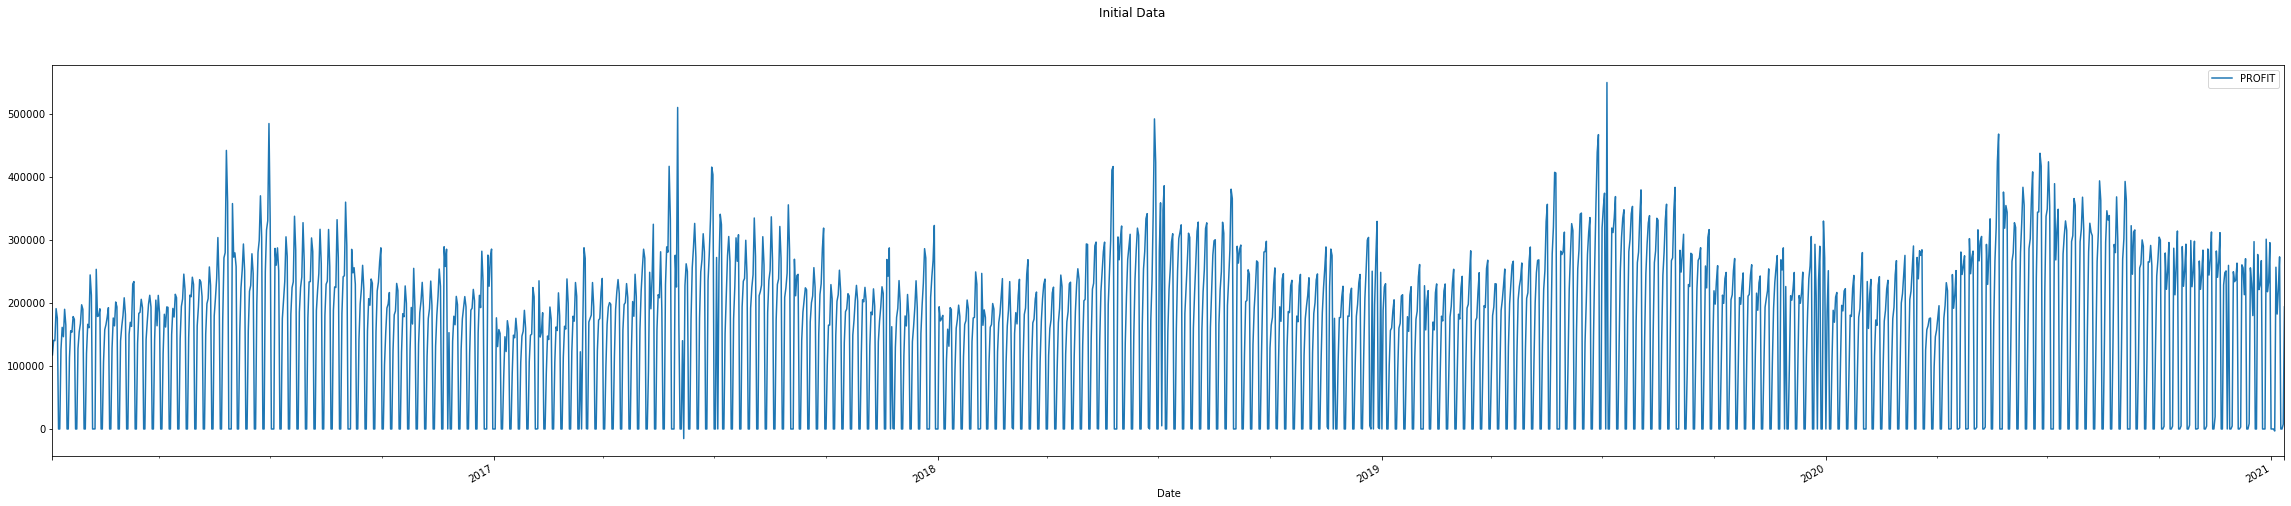

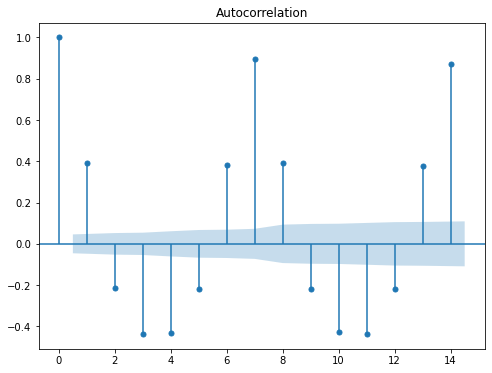

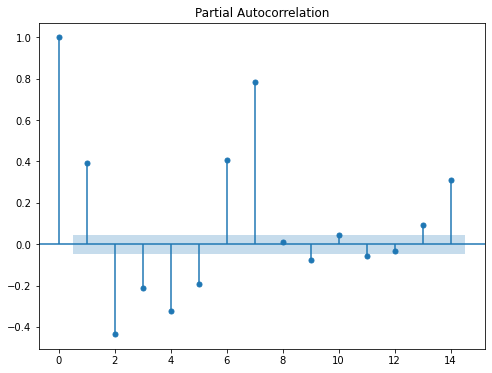

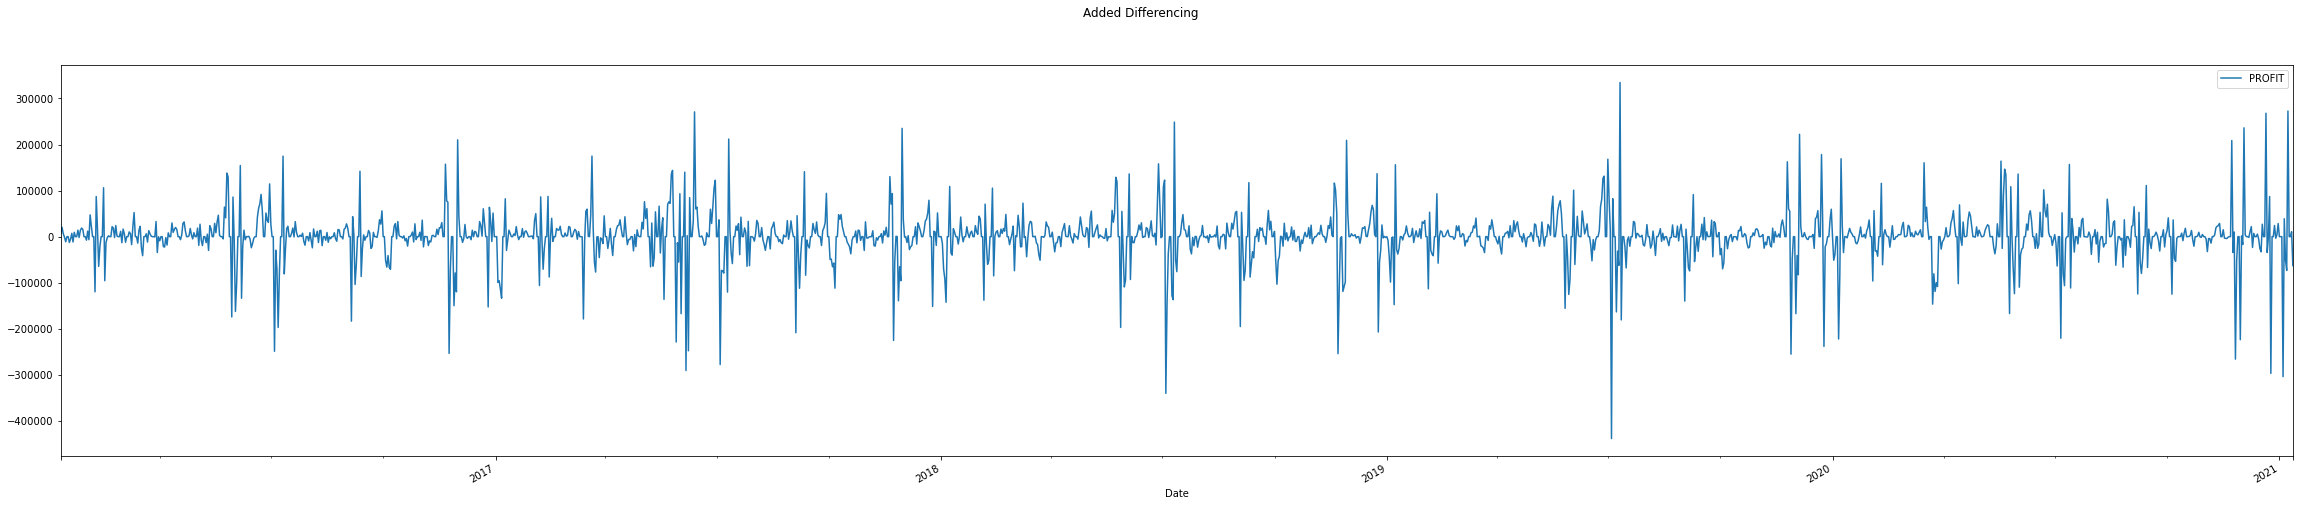

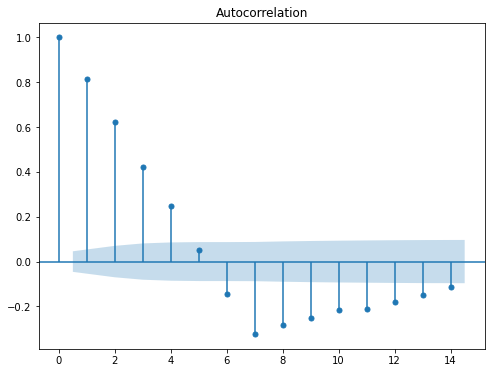

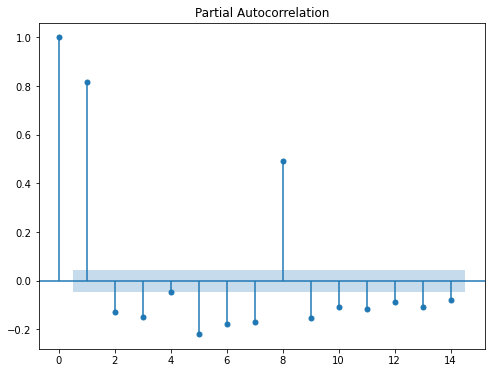

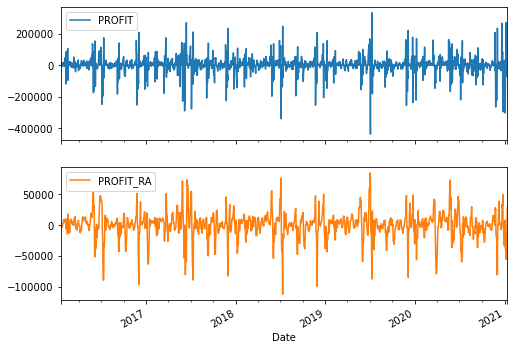

In [84]:
obj = schema_ML(schema, features)

Epoch 1/50
52/52 - 5s - loss: 0.0894 - val_loss: 0.0844
Epoch 2/50
52/52 - 0s - loss: 0.0713 - val_loss: 0.0828
Epoch 3/50
52/52 - 0s - loss: 0.0705 - val_loss: 0.0831
Epoch 4/50
52/52 - 0s - loss: 0.0694 - val_loss: 0.0827
Epoch 5/50
52/52 - 0s - loss: 0.0693 - val_loss: 0.0824
Epoch 6/50
52/52 - 0s - loss: 0.0689 - val_loss: 0.0832
Epoch 7/50
52/52 - 0s - loss: 0.0683 - val_loss: 0.0828
Epoch 8/50
52/52 - 0s - loss: 0.0670 - val_loss: 0.0819
Epoch 9/50
52/52 - 0s - loss: 0.0665 - val_loss: 0.0845
Epoch 10/50
52/52 - 0s - loss: 0.0658 - val_loss: 0.0817
Epoch 11/50
52/52 - 0s - loss: 0.0651 - val_loss: 0.0820
Epoch 12/50
52/52 - 0s - loss: 0.0652 - val_loss: 0.0821
Epoch 13/50
52/52 - 0s - loss: 0.0646 - val_loss: 0.0833
Epoch 14/50
52/52 - 0s - loss: 0.0650 - val_loss: 0.0814
Epoch 15/50
52/52 - 0s - loss: 0.0640 - val_loss: 0.0812
Epoch 16/50
52/52 - 0s - loss: 0.0641 - val_loss: 0.0826
Epoch 17/50
52/52 - 0s - loss: 0.0647 - val_loss: 0.0822
Epoch 18/50
52/52 - 0s - loss: 0.0637 - 

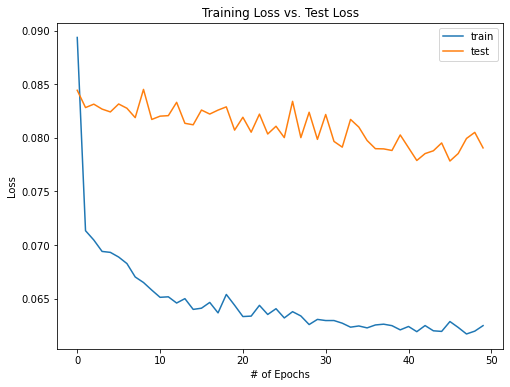

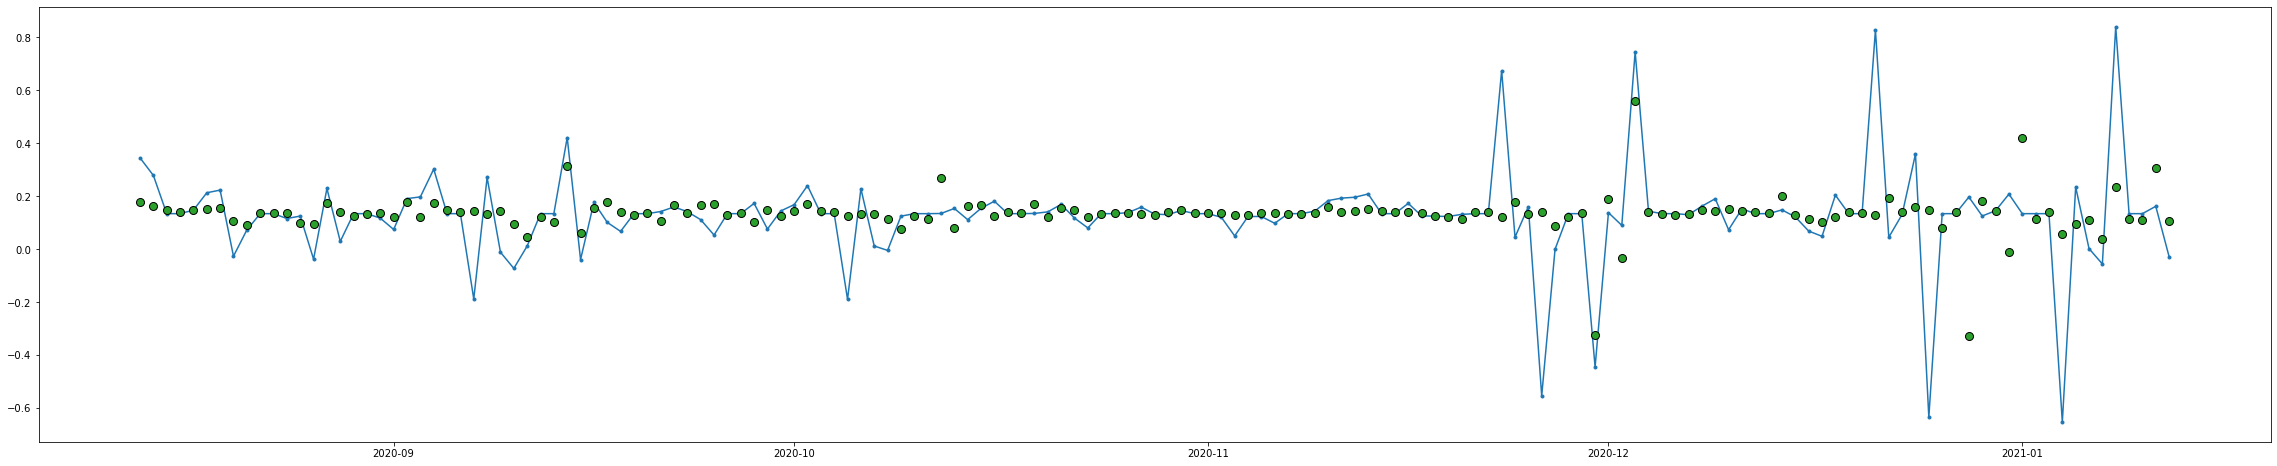

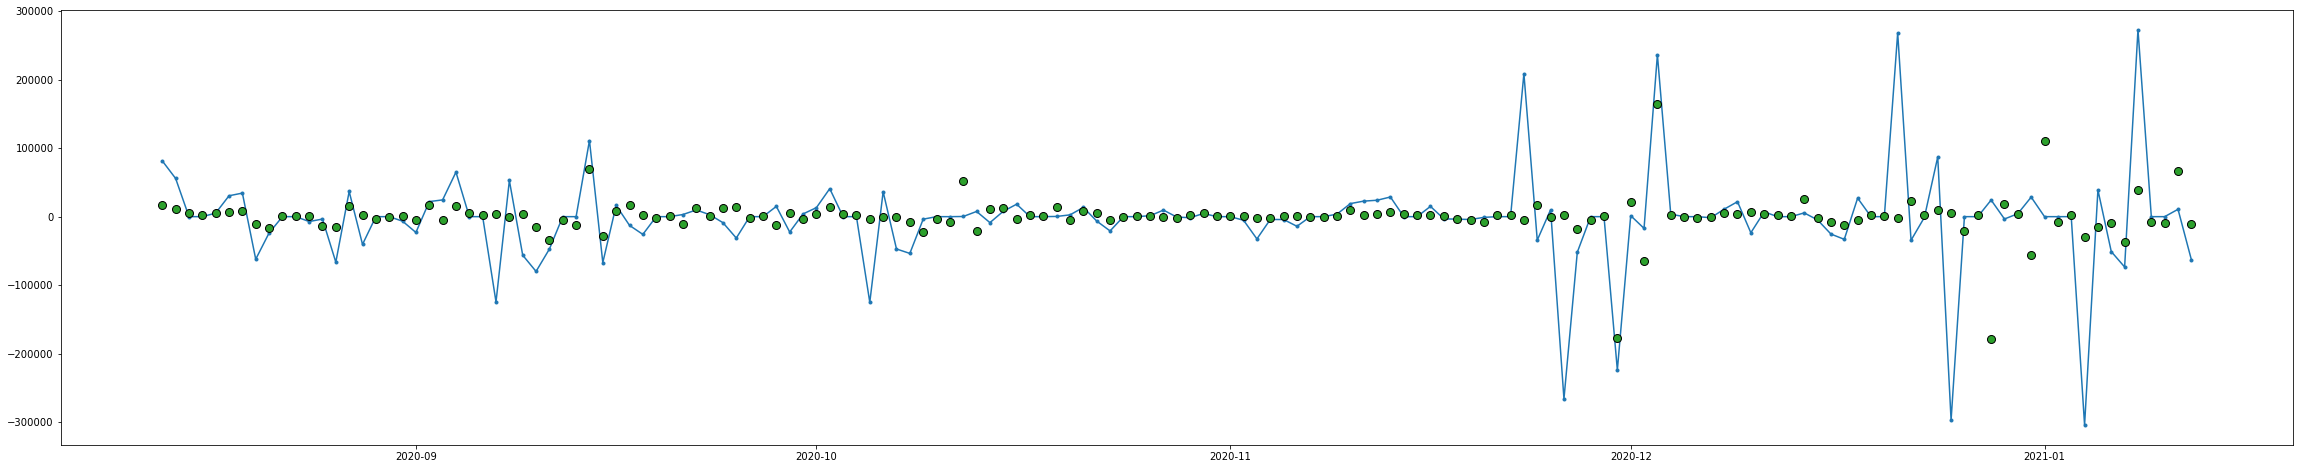

In [82]:
MONITOR = 'val_loss'
PATIENCE = 50
RESTORE_BEST_WEIGHTS = True
ES = tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=PATIENCE, 
                                    restore_best_weights=RESTORE_BEST_WEIGHTS)

LOSS = 'mae'
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001)
EPOCHS = 50
CALLBACKS = [ES]
VERBOSE = 2

model_params = Model_Params(LOSS, OPTIMIZER, EPOCHS, CALLBACKS, VERBOSE)
model_name = 'Base LSTM'
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1)
])

obj.evaluate_and_plot(model_name=model_name, model=model, model_params=model_params)


            PROFIT (t-1)    CES (t-1)     QTY (t-1)  PROFIT (t-7)  \
Date                                                                
2016-01-25        0.0000      0.00000      0.000000   -12607.1407   
2016-01-26    14160.2517   1944.57327   1245.750000    -5333.5743   
2016-01-27    -1830.9696  -1568.37101  -1479.000001     7175.5023   
2016-01-28    13688.6741    446.84299   1550.666666   -11551.1733   
2016-01-29    18711.5589    720.24642   1573.666669     9328.5603   
...                  ...          ...           ...           ...   
2020-07-07  -220654.3536 -46248.21964 -41091.333334    -6559.9561   
2020-07-08    51758.7658  15622.68476  15394.166666     4440.4635   
2020-07-09   -80488.8002 -14167.63771 -12607.208331   -13553.3990   
2020-07-10  -106549.2701 -15204.42914 -15273.750000   -63714.7981   
2020-07-11    -4715.6567    375.71020  -1026.583334        0.0000   

              CES (t-7)     QTY (t-7)  PROFIT (t-14)   CES (t-14)  \
Date                             

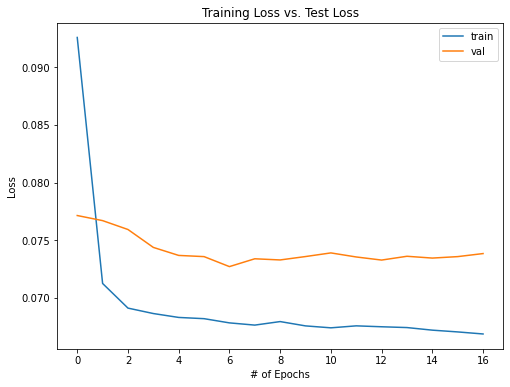

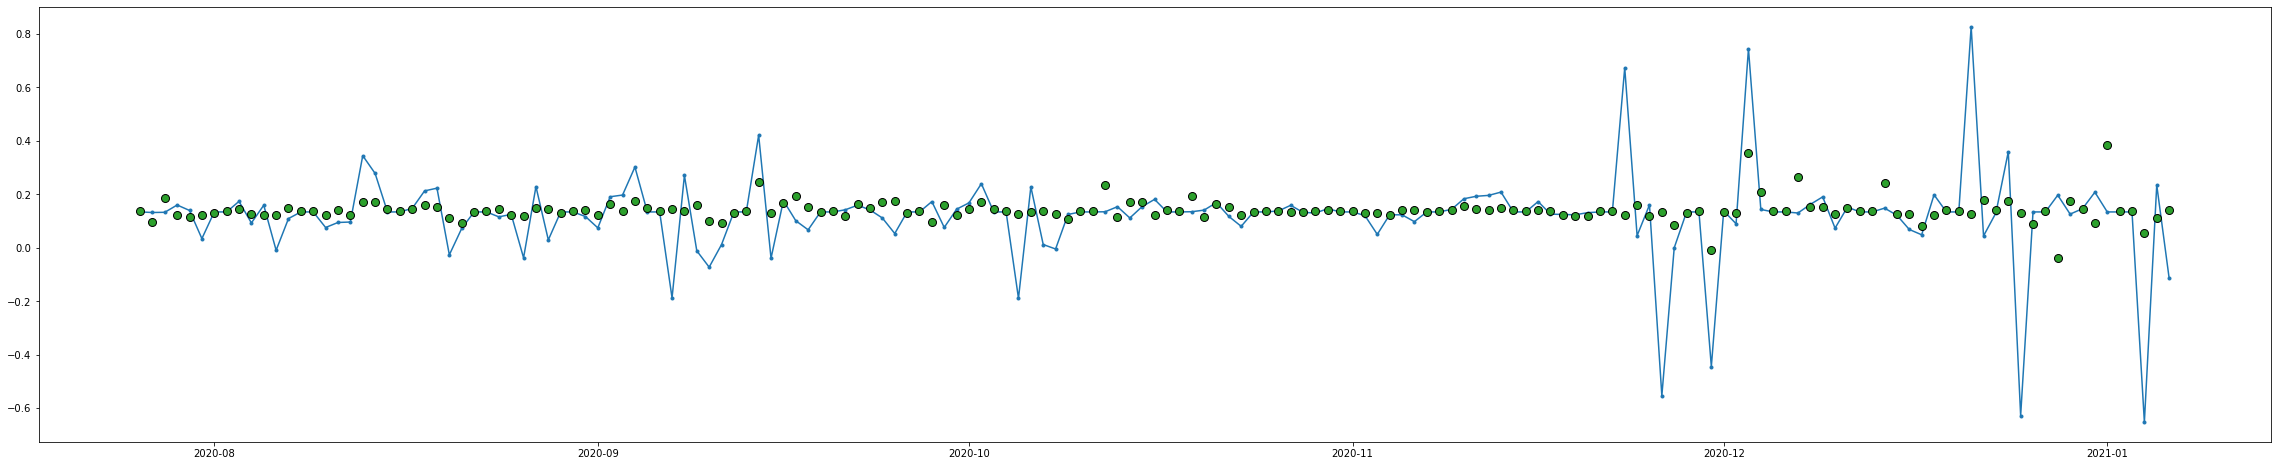

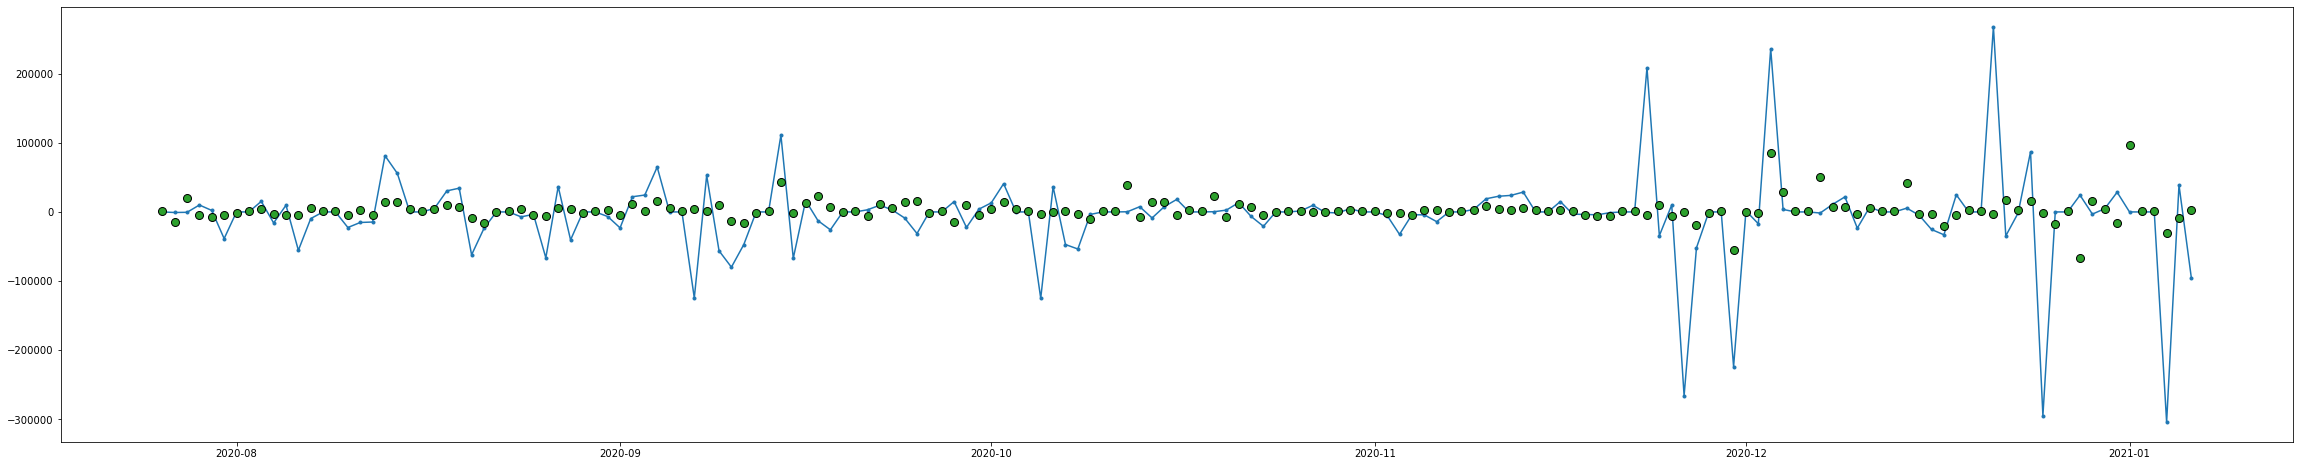

predictions


In [203]:
MONITOR = 'val_loss'
PATIENCE = 10
RESTORE_BEST_WEIGHTS = True
ES = tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=PATIENCE, 
                                    restore_best_weights=RESTORE_BEST_WEIGHTS)

LOSS = 'mae'
OPTIMIZER = 'adam'
EPOCHS = 500
CALLBACKS = [ES]
VERBOSE = 2

model_params = Model_Params(LOSS, OPTIMIZER, EPOCHS, CALLBACKS, VERBOSE)
model_name = 'LSTM_1'
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dense(1)
])

obj.evaluate_and_plot(model_name=model_name, model=model, model_params=model_params)


Epoch 1/500
52/52 - 5s - loss: 0.0791 - val_loss: 0.0495
Epoch 2/500
52/52 - 0s - loss: 0.0299 - val_loss: 0.0160
Epoch 3/500
52/52 - 0s - loss: 0.0210 - val_loss: 0.0151
Epoch 4/500
52/52 - 0s - loss: 0.0203 - val_loss: 0.0179
Epoch 5/500
52/52 - 0s - loss: 0.0203 - val_loss: 0.0146
Epoch 6/500
52/52 - 0s - loss: 0.0196 - val_loss: 0.0151
Epoch 7/500
52/52 - 0s - loss: 0.0196 - val_loss: 0.0160
Epoch 8/500
52/52 - 0s - loss: 0.0196 - val_loss: 0.0152
Epoch 9/500
52/52 - 0s - loss: 0.0190 - val_loss: 0.0148
Epoch 10/500
52/52 - 0s - loss: 0.0194 - val_loss: 0.0148
Epoch 11/500
52/52 - 0s - loss: 0.0187 - val_loss: 0.0159
Epoch 12/500
52/52 - 0s - loss: 0.0184 - val_loss: 0.0149
Epoch 13/500
52/52 - 0s - loss: 0.0190 - val_loss: 0.0158
Epoch 14/500
52/52 - 0s - loss: 0.0189 - val_loss: 0.0146
Epoch 15/500
52/52 - 0s - loss: 0.0185 - val_loss: 0.0149
Epoch 16/500
52/52 - 0s - loss: 0.0186 - val_loss: 0.0142
Epoch 17/500
52/52 - 0s - loss: 0.0188 - val_loss: 0.0148
Epoch 18/500
52/52 - 0s

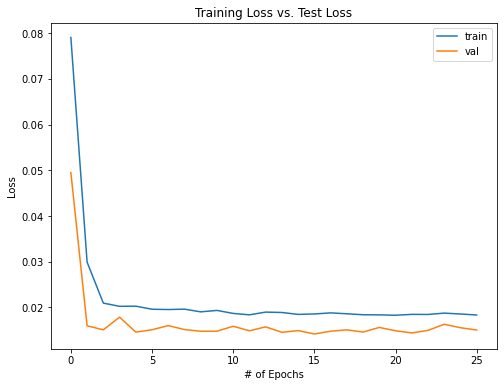

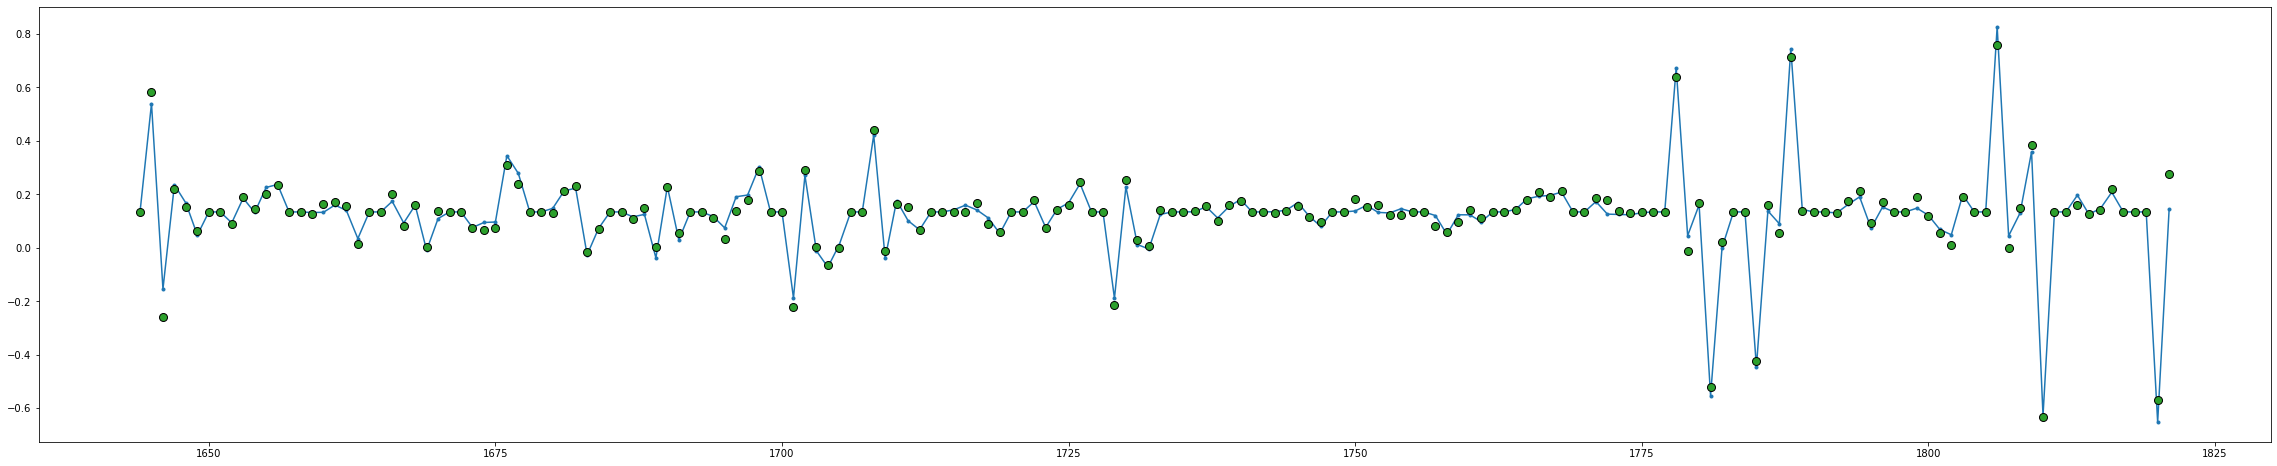

In [10]:
MONITOR = 'val_loss'
PATIENCE = 10
RESTORE_BEST_WEIGHTS = True
ES = tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=PATIENCE, 
                                    restore_best_weights=RESTORE_BEST_WEIGHTS)

LOSS = 'mae'
OPTIMIZER = 'adam'
EPOCHS = 500
CALLBACKS = [ES]
VERBOSE = 2

model_params = Model_Params(LOSS, OPTIMIZER, EPOCHS, CALLBACKS, VERBOSE)
model_name = 'LSTM_2'
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dense(1)
])

obj.evaluate_and_plot(model_name=model_name, model=model, model_params=model_params)


Epoch 1/800
52/52 - 5s - loss: 0.0807 - val_loss: 0.0703
Epoch 2/800
52/52 - 0s - loss: 0.0696 - val_loss: 0.0744
Epoch 3/800
52/52 - 0s - loss: 0.0690 - val_loss: 0.0747
Epoch 4/800
52/52 - 0s - loss: 0.0686 - val_loss: 0.0703
Epoch 5/800
52/52 - 0s - loss: 0.0665 - val_loss: 0.0703
Epoch 6/800
52/52 - 0s - loss: 0.0652 - val_loss: 0.0687
Epoch 7/800
52/52 - 0s - loss: 0.0650 - val_loss: 0.0693
Epoch 8/800
52/52 - 0s - loss: 0.0658 - val_loss: 0.0679
Epoch 9/800
52/52 - 0s - loss: 0.0655 - val_loss: 0.0697
Epoch 10/800
52/52 - 0s - loss: 0.0643 - val_loss: 0.0694
Epoch 11/800
52/52 - 0s - loss: 0.0651 - val_loss: 0.0713
Epoch 12/800
52/52 - 0s - loss: 0.0654 - val_loss: 0.0712
Epoch 13/800
52/52 - 0s - loss: 0.0650 - val_loss: 0.0718
Epoch 14/800
52/52 - 0s - loss: 0.0645 - val_loss: 0.0694
Epoch 15/800
52/52 - 0s - loss: 0.0652 - val_loss: 0.0684
Epoch 16/800
52/52 - 0s - loss: 0.0650 - val_loss: 0.0693
Epoch 17/800
52/52 - 0s - loss: 0.0650 - val_loss: 0.0675
Epoch 18/800
52/52 - 0s

Epoch 142/800
52/52 - 0s - loss: 0.0517 - val_loss: 0.0662
Epoch 143/800
52/52 - 0s - loss: 0.0519 - val_loss: 0.0650
Epoch 144/800
52/52 - 0s - loss: 0.0516 - val_loss: 0.0664
Epoch 145/800
52/52 - 0s - loss: 0.0517 - val_loss: 0.0667
Epoch 146/800
52/52 - 0s - loss: 0.0518 - val_loss: 0.0693
Epoch 147/800
52/52 - 0s - loss: 0.0509 - val_loss: 0.0691
Epoch 148/800
52/52 - 0s - loss: 0.0530 - val_loss: 0.0700
Epoch 149/800
52/52 - 0s - loss: 0.0521 - val_loss: 0.0667
Epoch 150/800
52/52 - 0s - loss: 0.0517 - val_loss: 0.0653
Epoch 151/800
52/52 - 0s - loss: 0.0524 - val_loss: 0.0640
Epoch 152/800
52/52 - 0s - loss: 0.0521 - val_loss: 0.0667
Epoch 153/800
52/52 - 0s - loss: 0.0515 - val_loss: 0.0651
Epoch 154/800
52/52 - 0s - loss: 0.0514 - val_loss: 0.0637
Epoch 155/800
52/52 - 0s - loss: 0.0510 - val_loss: 0.0668
Epoch 156/800
52/52 - 0s - loss: 0.0520 - val_loss: 0.0645
Epoch 157/800
52/52 - 0s - loss: 0.0515 - val_loss: 0.0659
Epoch 158/800
52/52 - 0s - loss: 0.0516 - val_loss: 0.06

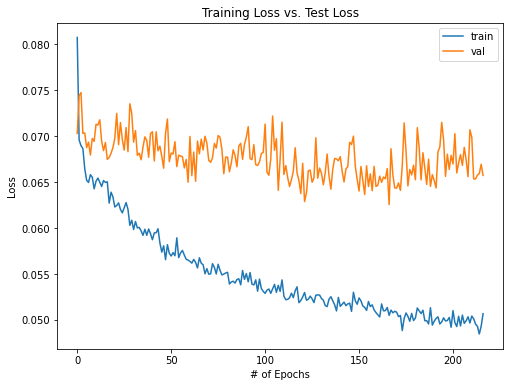

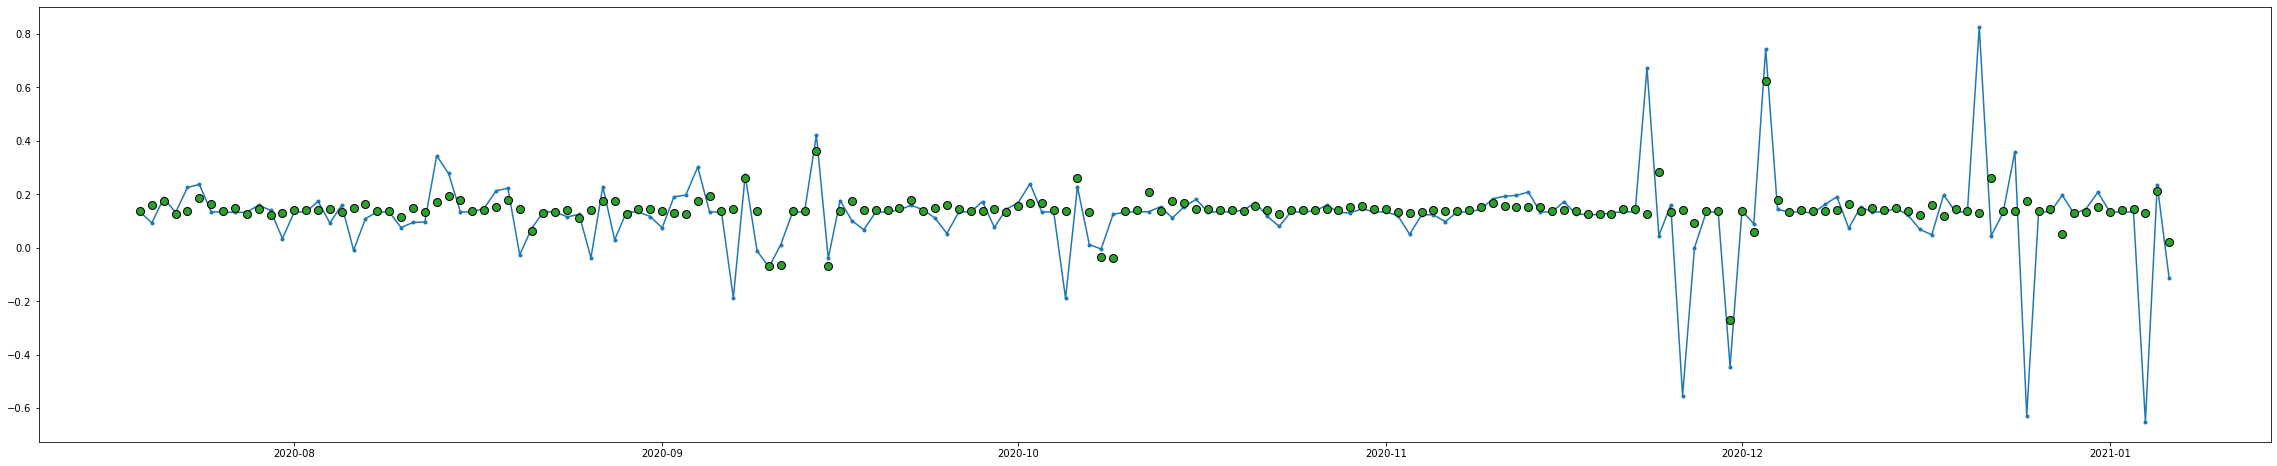

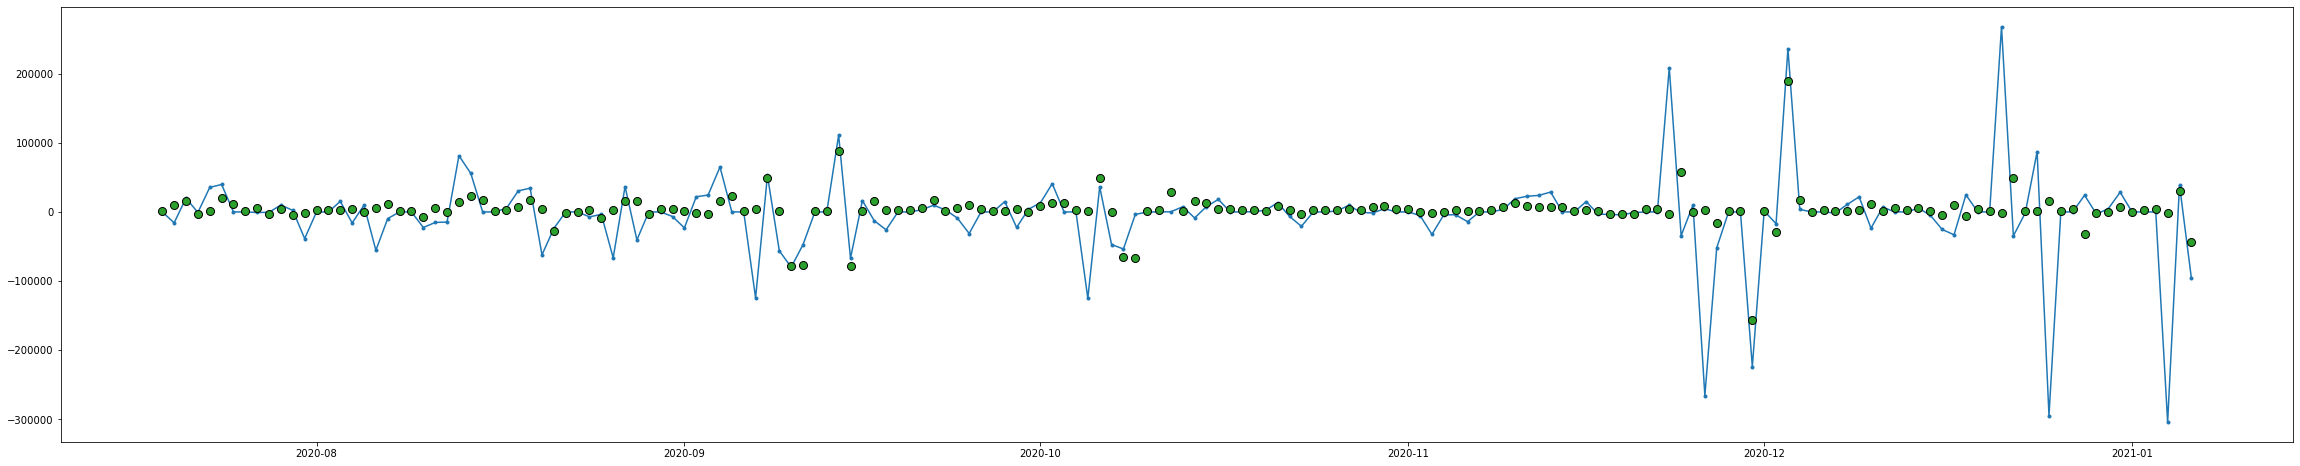

In [230]:
MONITOR = 'val_loss'
PATIENCE = 50
RESTORE_BEST_WEIGHTS = True
ES = tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=PATIENCE, 
                                    restore_best_weights=RESTORE_BEST_WEIGHTS)

LOSS = 'mae'
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.01)
EPOCHS = 800
CALLBACKS = [ES]
VERBOSE = 2

model_params = Model_Params(LOSS, OPTIMIZER, EPOCHS, CALLBACKS, VERBOSE)
model_name = 'LSTM_3'
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(1)
])

obj.evaluate_and_plot(model_name=model_name, model=model, model_params=model_params)

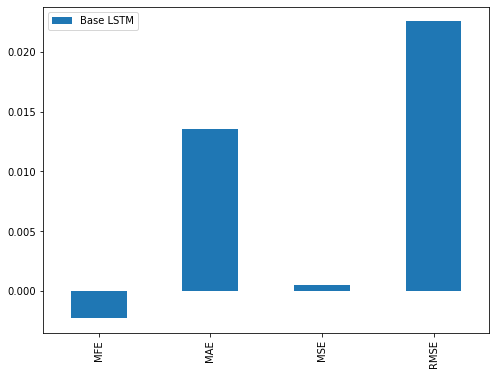

      Base LSTM
MFE   -0.002275
MAE    0.013556
MSE    0.000508
RMSE   0.022544


In [60]:
obj.performance_metrics()

Epoch 1/500
52/52 - 3s - loss: 0.0889 - val_loss: 0.0829
Epoch 2/500
52/52 - 0s - loss: 0.0713 - val_loss: 0.0811
Epoch 3/500
52/52 - 0s - loss: 0.0698 - val_loss: 0.0801
Epoch 4/500
52/52 - 0s - loss: 0.0694 - val_loss: 0.0796
Epoch 5/500
52/52 - 0s - loss: 0.0691 - val_loss: 0.0788
Epoch 6/500
52/52 - 0s - loss: 0.0690 - val_loss: 0.0800
Epoch 7/500
52/52 - 0s - loss: 0.0688 - val_loss: 0.0791
Epoch 8/500
52/52 - 0s - loss: 0.0684 - val_loss: 0.0792
Epoch 9/500
52/52 - 0s - loss: 0.0680 - val_loss: 0.0792
Epoch 10/500
52/52 - 0s - loss: 0.0675 - val_loss: 0.0782
Epoch 11/500
52/52 - 0s - loss: 0.0666 - val_loss: 0.0785
Epoch 12/500
52/52 - 0s - loss: 0.0655 - val_loss: 0.0781
Epoch 13/500
52/52 - 0s - loss: 0.0652 - val_loss: 0.0773
Epoch 14/500
52/52 - 0s - loss: 0.0641 - val_loss: 0.0760
Epoch 15/500
52/52 - 0s - loss: 0.0639 - val_loss: 0.0764
Epoch 16/500
52/52 - 0s - loss: 0.0638 - val_loss: 0.0751
Epoch 17/500
52/52 - 0s - loss: 0.0631 - val_loss: 0.0753
Epoch 18/500
52/52 - 0s

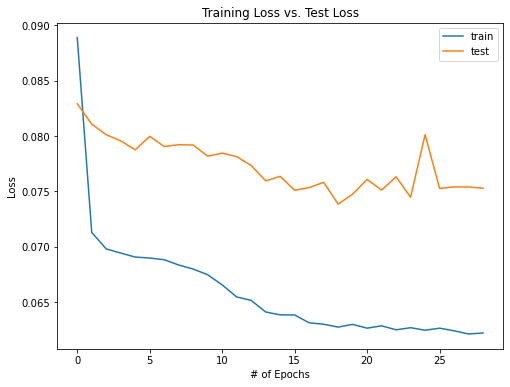

ValueError: Found array with dim 3. Estimator expected <= 2.

In [20]:
MONITOR = 'val_loss'
PATIENCE = 10
RESTORE_BEST_WEIGHTS = True
ES = tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=PATIENCE, 
                                    restore_best_weights=RESTORE_BEST_WEIGHTS)

LOSS = 'mae'
OPTIMIZER = 'adam'
EPOCHS = 500
CALLBACKS = [ES]
VERBOSE = 2

model_params = Model_Params(LOSS, OPTIMIZER, EPOCHS, CALLBACKS, VERBOSE)
model_name = 'LSTM_3'
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=20, kernel_size=1, strides=2, padding='valid'),
    tf.keras.layers.GRU(20, return_sequences=True),
    tf.keras.layers.GRU(20, return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))
])

obj.evaluate_and_plot(model_name=model_name, model=model, model_params=model_params)